Essay Writer

In [29]:
from dotenv import load_dotenv

_ = load_dotenv()

In [30]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [31]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [32]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [33]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [34]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [35]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [36]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [37]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [38]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [39]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [40]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [41]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [42]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [43]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [16]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [44]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [45]:
builder = StateGraph(AgentState)

In [46]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [47]:
builder.set_entry_point("planner")

In [48]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [49]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [50]:
graph = builder.compile(checkpointer=memory)

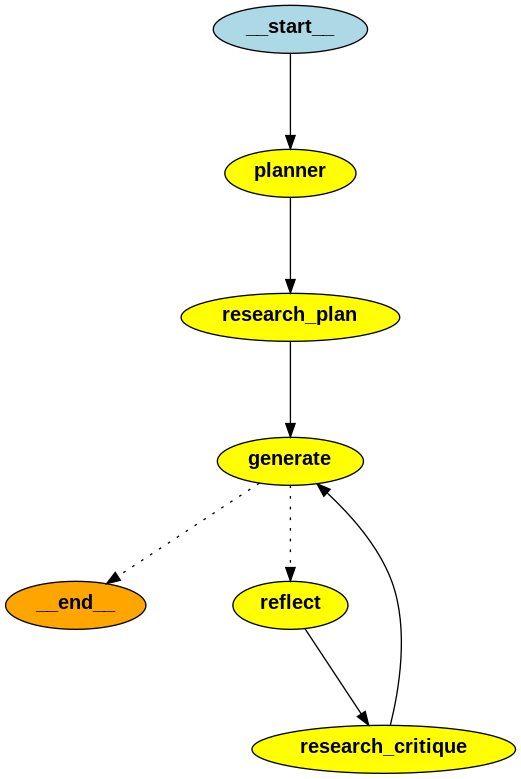

In [51]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [57]:
from pprint import pprint 
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "What is the difference between pytorch and tensorflow",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    pprint(s)

{'planner': {'plan': 'I. Introduction\n'
                     '    A. Brief overview of PyTorch and TensorFlow\n'
                     '    B. Importance of understanding the differences '
                     'between the two frameworks\n'
                     '\n'
                     'II. History and Background\n'
                     '    A. Origins of PyTorch\n'
                     '    B. Origins of TensorFlow\n'
                     '    C. Key contributors and organizations behind each '
                     'framework\n'
                     '\n'
                     'III. Architecture and Design\n'
                     '    A. Computational graph structure in TensorFlow\n'
                     '    B. Dynamic computation graph in PyTorch\n'
                     '    C. Eager execution in PyTorch vs. static graph in '
                     'TensorFlow\n'
                     '\n'
                     'IV. Popularity and Community Support\n'
                     '    A. Compari

{'generate': {'draft': '# Difference Between PyTorch and TensorFlow\n'
                       '\n'
                       '## I. Introduction\n'
                       'A. PyTorch and TensorFlow Overview\n'
                       'B. Importance of Understanding Framework Differences\n'
                       '\n'
                       '## II. History and Background\n'
                       'A. Origins of PyTorch\n'
                       'B. Origins of TensorFlow\n'
                       'C. Key Contributors and Organizations\n'
                       '\n'
                       '## III. Architecture and Design\n'
                       "A. TensorFlow's Computational Graph Structure\n"
                       "B. PyTorch's Dynamic Computation Graph\n"
                       'C. Eager Execution vs. Static Graph\n'
                       '\n'
                       '## IV. Popularity and Community Support\n'
                       'A. Community Size and Activity\n'
                    

{'generate': {'draft': '**Title: A Comparative Analysis of PyTorch and '
                       'TensorFlow: Understanding the Key Differences**\n'
                       '\n'
                       '**I. Introduction**\n'
                       'In the realm of deep learning frameworks, PyTorch and '
                       'TensorFlow stand out as two prominent tools that power '
                       'a wide range of machine learning applications. '
                       'Understanding the nuances and disparities between '
                       'these frameworks is crucial for developers and data '
                       'scientists aiming to leverage the best technology for '
                       'their projects.\n'
                       '\n'
                       '**II. History and Background**\n'
                       "PyTorch, developed by Facebook's AI Research lab, and "
                       'TensorFlow, created by Google Brain, have distinct '
                       